<a href="https://www.kaggle.com/code/battugschoijil/facial-expression-recognition-8?scriptVersionId=113295384" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# 1. Installing Dependencies

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

import tensorflow as tf
from tensorflow.keras import models
from tensorflow.keras.layers import Activation, BatchNormalization, Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.utils import to_categorical

# 2. Creating Path

In [2]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        print(os.listdir("../input"))

/kaggle/input/challenges-in-representation-learning-facial-expression-recognition-challenge/icml_face_data.csv
['challenges-in-representation-learning-facial-expression-recognition-challenge']
/kaggle/input/challenges-in-representation-learning-facial-expression-recognition-challenge/fer2013.tar.gz
['challenges-in-representation-learning-facial-expression-recognition-challenge']
/kaggle/input/challenges-in-representation-learning-facial-expression-recognition-challenge/example_submission.csv
['challenges-in-representation-learning-facial-expression-recognition-challenge']
/kaggle/input/challenges-in-representation-learning-facial-expression-recognition-challenge/train.csv
['challenges-in-representation-learning-facial-expression-recognition-challenge']
/kaggle/input/challenges-in-representation-learning-facial-expression-recognition-challenge/test.csv
['challenges-in-representation-learning-facial-expression-recognition-challenge']


# 3. Loading the Dataset

In [3]:
data = pd.read_csv('/kaggle/input/challenges-in-representation-learning-facial-expression-recognition-challenge/icml_face_data.csv')

In [4]:
data.head()

,emotion,Usage,pixels
0,0,Training,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,Training,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,Training,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,Training,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,Training,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


# 4. Function to Plot the Data

In [5]:
def prepare_data(data):
    """ Prepare data for modeling 
        input: data frame with labels und pixel data
        output: image and label array """
    
    image_array = np.zeros(shape=(len(data), 48, 48))
    image_label = np.array(list(map(int, data['emotion'])))
    
    for i, row in enumerate(data.index):
        image = np.fromstring(data.loc[row, ' pixels'], dtype=int, sep=' ')
        image = np.reshape(image, (48, 48))
        image_array[i] = image
        
    return image_array, image_label
  
def plot_examples(label=0):
    fig, axs = plt.subplots(1, 5, figsize=(25, 12))
    fig.subplots_adjust(hspace = .2, wspace=.2)
    axs = axs.ravel()
    for i in range(5):
        idx = data[data['emotion']==label].index[i]
        axs[i].imshow(train_images[idx][:,:,0], cmap='gray')
        axs[i].set_title(emotions[train_labels[idx].argmax()])
        axs[i].set_xticklabels([])
        axs[i].set_yticklabels([])

def plot_all_emotions():
    fig, axs = plt.subplots(1, 7, figsize=(30, 12))
    fig.subplots_adjust(hspace = .2, wspace=.2)
    axs = axs.ravel()
    for i in range(7):
        idx = data[data['emotion']==i].index[i]
        axs[i].imshow(train_images[idx][:,:,0], cmap='gray')
        axs[i].set_title(emotions[train_labels[idx].argmax()])
        axs[i].set_xticklabels([])
        axs[i].set_yticklabels([])

def plot_image_and_emotion(test_image_array, test_image_label, pred_test_labels, image_number):
    """ Function to plot the image and compare the prediction results with the label """
    
    fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=False)
    
    bar_label = emotions.values()
    
    axs[0].imshow(test_image_array[image_number], 'gray')
    axs[0].set_title(emotions[test_image_label[image_number]])
    
    axs[1].bar(bar_label, pred_test_labels[image_number], color='orange', alpha=0.7)
    axs[1].grid()
    
    plt.show()

def plot_compare_distributions(array1, array2, title1='', title2=''):
    df_array1 = pd.DataFrame()
    df_array2 = pd.DataFrame()
    df_array1['emotion'] = array1.argmax(axis=1)
    df_array2['emotion'] = array2.argmax(axis=1)
    
    fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=False)
    x = emotions.values()
    
    y = df_array1['emotion'].value_counts()
    keys_missed = list(set(emotions.keys()).difference(set(y.keys())))
    for key_missed in keys_missed:
        y[key_missed] = 0
    axs[0].bar(x, y.sort_index(), color='orange')
    axs[0].set_title(title1)
    axs[0].grid()
    
    y = df_array2['emotion'].value_counts()
    keys_missed = list(set(emotions.keys()).difference(set(y.keys())))
    for key_missed in keys_missed:
        y[key_missed] = 0
    axs[1].bar(x, y.sort_index())
    axs[1].set_title(title2)
    axs[1].grid()
    
    plt.show()

# 5. Callback Functions

In [6]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

def callbackFunction(modelName):
  checkpoint = ModelCheckpoint(f"Checkpoints/{modelName}.h5", monitor = "val_accuracy", save_best_only = True, mode = "auto", verbose = 1)
  early_stopping = EarlyStopping(monitor = "val_accuracy", patience = 10, verbose = 1)
  callbacks = [early_stopping, checkpoint]
  return callbacks

# 6. More about the dataset

In [7]:
data[' Usage'].value_counts()

Training       28709
PublicTest      3589
PrivateTest     3589
Name:  Usage, dtype: int64

# 7. Creating the label dictionary

In [8]:
emotions = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}

# 8. Training, Testing and Validation Split

In [9]:
train_image_array, train_image_label = prepare_data(data[data[' Usage']=='Training'])
val_image_array, val_image_label = prepare_data(data[data[' Usage']=='PrivateTest'])
test_image_array, test_image_label = prepare_data(data[data[' Usage']=='PublicTest'])

In [10]:
train_images = train_image_array.reshape((train_image_array.shape[0], 48, 48, 1))
train_images = train_images.astype('float32')/255

val_images = val_image_array.reshape((val_image_array.shape[0], 48, 48, 1))
val_images = val_images.astype('float32')/255

test_images = test_image_array.reshape((test_image_array.shape[0], 48, 48, 1))
test_images = test_images.astype('float32')/255

In [11]:
train_labels = to_categorical(train_image_label)
val_labels = to_categorical(val_image_label)
test_labels = to_categorical(test_image_label)

# 9. Examples from the dataset

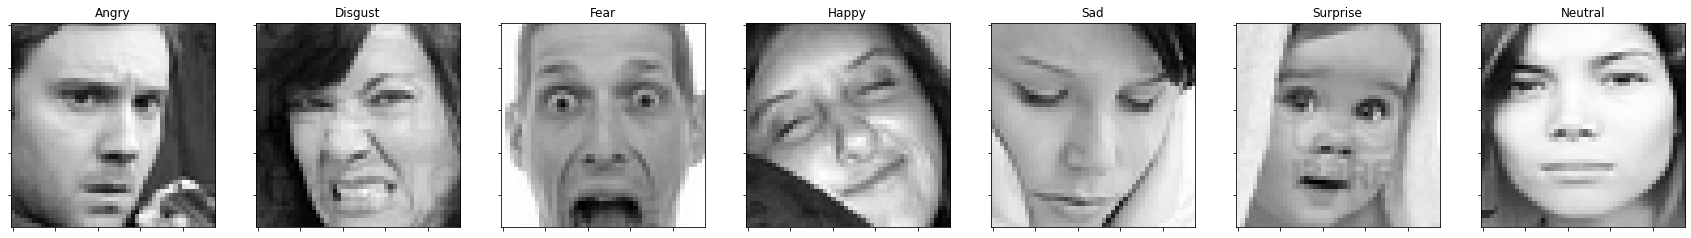

In [12]:
plot_all_emotions()

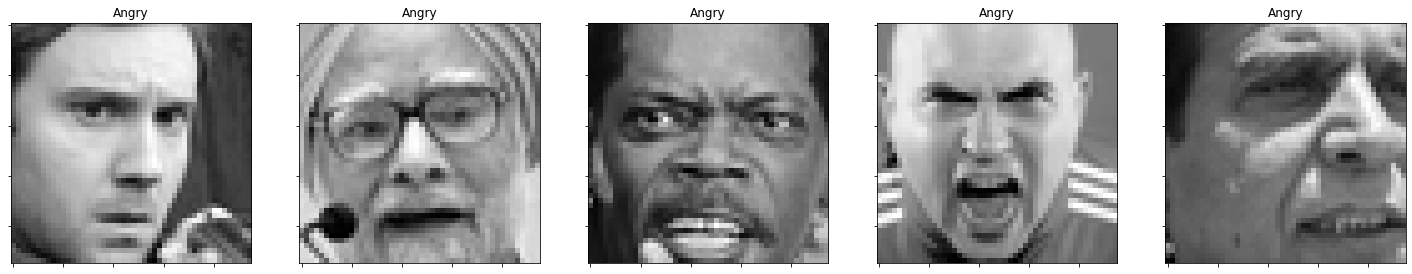

In [13]:
plot_examples(label=0)

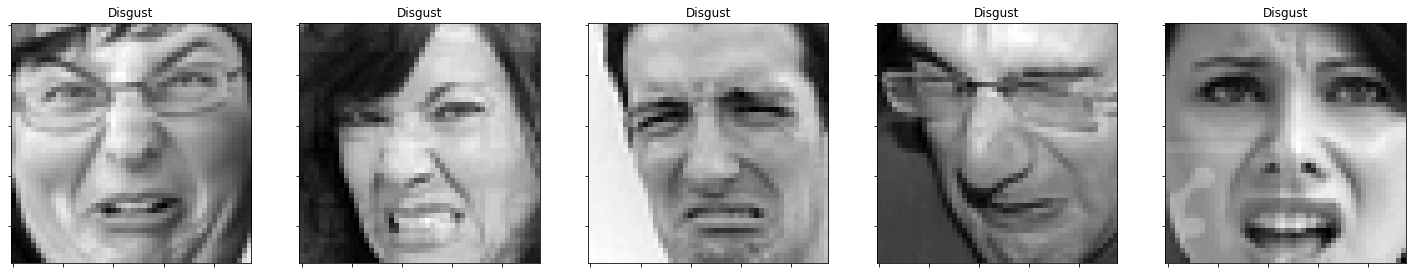

In [14]:
plot_examples(label=1)

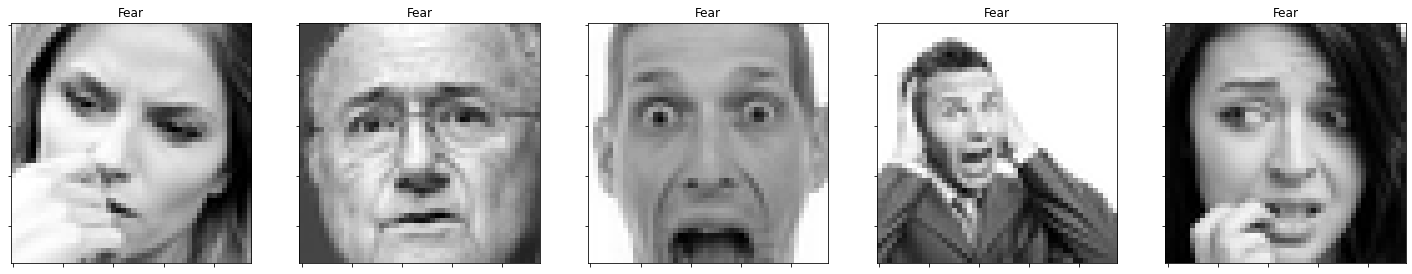

In [15]:
plot_examples(label=2)

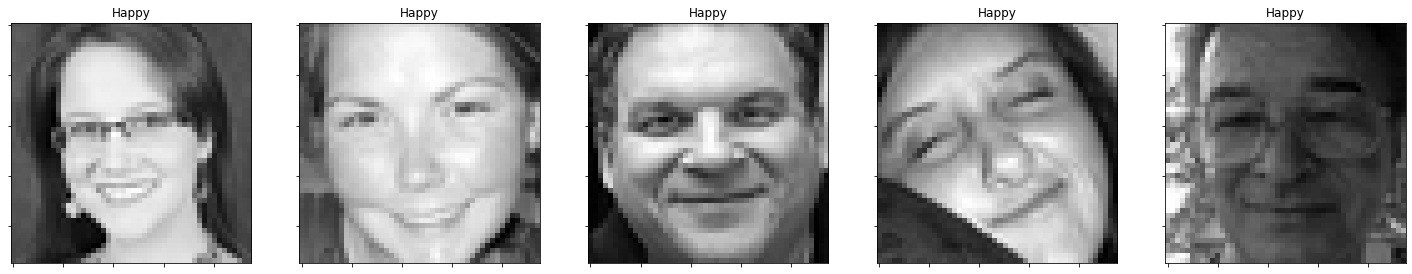

In [16]:
plot_examples(label=3)

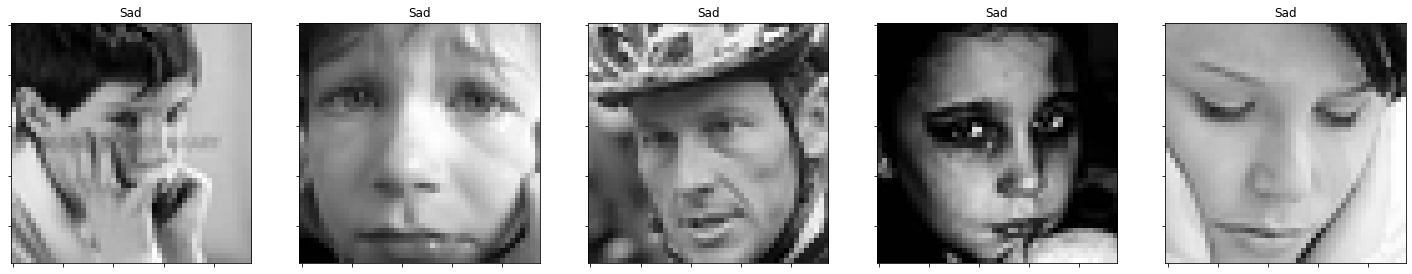

In [17]:
plot_examples(label=4)

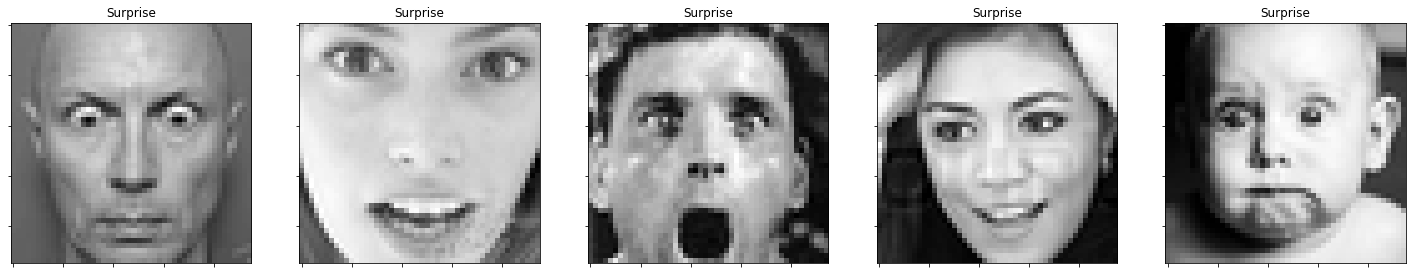

In [18]:
plot_examples(label=5)

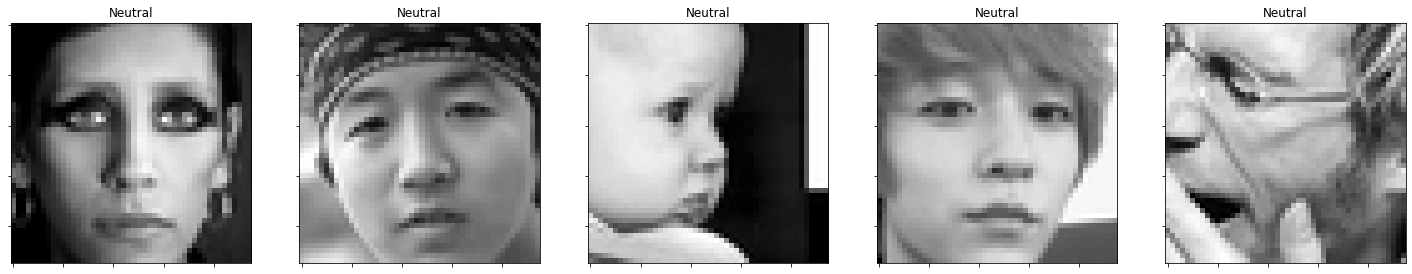

In [19]:
plot_examples(label=6)

# 10. Comparison Plots

1. Train Labels and Validation Labels

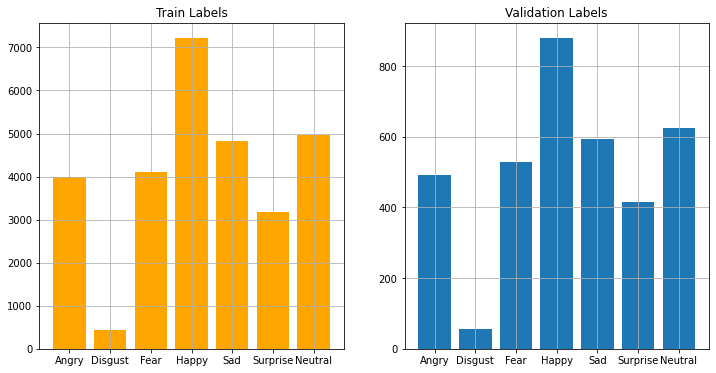

In [20]:
plot_compare_distributions(train_labels, val_labels, title1='Train Labels', title2='Validation Labels')

2. Train Labels and Test Labels

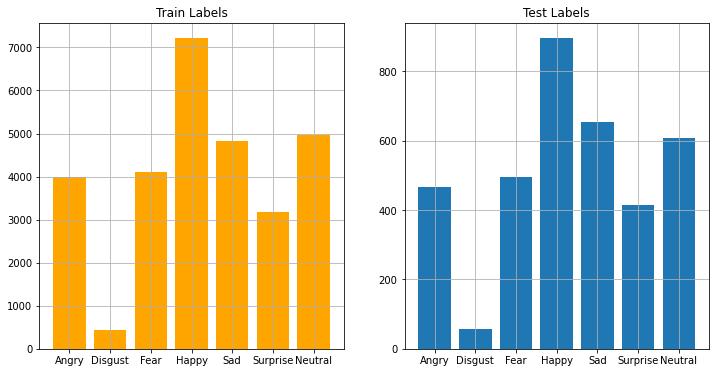

In [21]:
plot_compare_distributions(train_labels, test_labels, title1='Train Labels', title2='Test Labels')

# 11. Weights

In [22]:
class_weight = dict(zip(range(0, 7), (((data[data[' Usage']=='Training']['emotion'].value_counts()).sort_index())/len(data[data[' Usage']=='Training']['emotion'])).tolist()))
class_weight

{0: 0.1391549688251071,
 1: 0.01518687519593159,
 2: 0.14270786164617366,
 3: 0.2513149186666202,
 4: 0.16823992476226968,
 5: 0.11045316799609878,
 6: 0.17294228290779895}

# 12. Custom Model 1
With Convolution Layers, Pooldown Layers and Dense Layers

In [23]:
model1 = models.Sequential()

model1.add(Conv2D(64, (3, 3), padding='same', activation='relu', input_shape=(48, 48, 1)))

model1.add(MaxPool2D((2, 2)))
model1.add(Conv2D(64, (3, 3), padding='same', activation='relu'))

model1.add(MaxPool2D((2, 2)))
model1.add(Conv2D(128, (3, 3), padding='same', activation='relu'))

model1.add(MaxPool2D((2, 2)))
model1.add(Conv2D(256, (3, 3), padding='same', activation='relu'))

model1.add(MaxPool2D((2, 2)))
model1.add(Flatten())
model1.add(Dense(256, activation='relu'))
model1.add(Dense(128, activation='relu'))

model1.add(Dense(7, activation='softmax'))

2022-12-08 15:00:03.260269: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-08 15:00:03.373394: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-08 15:00:03.374251: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-08 15:00:03.375381: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

The Model

In [24]:
model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 64)        640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 6, 6, 128)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 6, 6, 256)         2

Compiling the Model

In [25]:
model1.compile(optimizer=Adam(learning_rate=1e-3), loss='categorical_crossentropy', metrics=['accuracy'])

Training the Model

In [26]:
history1 = model1.fit(train_images, train_labels,
                    validation_data=(val_images, val_labels),
                    callbacks=callbackFunction('Case_1'),
                    class_weight = class_weight,
                    epochs=50,
                    batch_size=64)

2022-12-08 15:00:07.604735: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50


2022-12-08 15:00:09.218506: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


449/449 [==============================] - 11s 8ms/step - loss: 0.2723 - accuracy: 0.3020 - val_loss: 1.6106 - val_accuracy: 0.3859

Epoch 00001: val_accuracy improved from -inf to 0.38590, saving model to Checkpoints/Case_1.h5
Epoch 2/50
449/449 [==============================] - 3s 8ms/step - loss: 0.2210 - accuracy: 0.4419 - val_loss: 1.3558 - val_accuracy: 0.4815

Epoch 00002: val_accuracy improved from 0.38590 to 0.48147, saving model to Checkpoints/Case_1.h5
Epoch 3/50
449/449 [==============================] - 3s 8ms/step - loss: 0.1962 - accuracy: 0.5064 - val_loss: 1.2722 - val_accuracy: 0.5288

Epoch 00003: val_accuracy improved from 0.48147 to 0.52884, saving model to Checkpoints/Case_1.h5
Epoch 4/50
449/449 [==============================] - 3s 8ms/step - loss: 0.1779 - accuracy: 0.5564 - val_loss: 1.2850 - val_accuracy: 0.5288

Epoch 00004: val_accuracy did not improve from 0.52884
Epoch 5/50
449/449 [==============================] - 3s 7ms/step - loss: 0.1631 - accuracy:

Accuracy

In [27]:
train_loss, train_acc = model1.evaluate(train_images, train_labels)
print('Training Accuracy:', train_acc*100)
print('\n')

test_loss, test_acc = model1.evaluate(test_images, test_labels)
print('Testing Accuracy:', test_acc*100)
print('\n')

val_loss, val_acc = model1.evaluate(val_images, val_labels)
print('Validation Accuracy:', val_acc*100)

898/898 [==============================] - 3s 3ms/step - loss: 0.1770 - accuracy: 0.9476
Training Accuracy: 94.757741689682


113/113 [==============================] - 0s 3ms/step - loss: 2.9801 - accuracy: 0.5631
Testing Accuracy: 56.310951709747314


113/113 [==============================] - 0s 3ms/step - loss: 2.8313 - accuracy: 0.5798
Validation Accuracy: 57.98272490501404


Predictions

In [28]:
pred_test_labels1 = model1.predict(test_images)

Plots

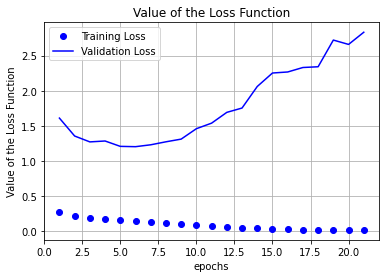

In [29]:
loss = history1.history['loss']
loss_val = history1.history['val_loss']
epochs = range(1, len(loss)+1)
plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, loss_val, 'b', label='Validation Loss')
plt.title('Value of the Loss Function')
plt.xlabel('epochs')
plt.ylabel('Value of the Loss Function')
plt.legend()
plt.grid()
plt.show()

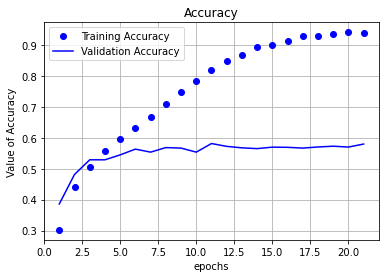

In [30]:
acc = history1.history['accuracy']
acc_val = history1.history['val_accuracy']
epochs = range(1, len(loss)+1)
plt.plot(epochs, acc, 'bo', label='Training Accuracy')
plt.plot(epochs, acc_val, 'b', label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('Value of Accuracy')
plt.legend()
plt.grid()
plt.show()

# 13. Custom Model 2
With Convolution Layers, Pooldown Layers, Dropout Layers and Dense Layers

In [31]:
model2 = models.Sequential()

model2.add(Conv2D(64, (3, 3), padding='same', activation='relu', input_shape=(48, 48, 1)))
model2.add(Dropout(0.25))

model2.add(MaxPool2D((2, 2)))
model2.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model2.add(Dropout(0.25))

model2.add(MaxPool2D((2, 2)))
model2.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model2.add(Dropout(0.25))

model2.add(MaxPool2D((2, 2)))
model2.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
model2.add(Dropout(0.25))

model2.add(MaxPool2D((2, 2)))
model2.add(Flatten())
model2.add(Dense(256, activation='relu'))
model2.add(Dense(128, activation='relu'))
model2.add(Dropout(0.25))

model2.add(Dense(7, activation='softmax'))

The Model

In [32]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 48, 48, 64)        640       
_________________________________________________________________
dropout (Dropout)            (None, 48, 48, 64)        0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 24, 24, 64)        36928     
_________________________________________________________________
dropout_1 (Dropout)          (None, 24, 24, 64)        0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 12, 12, 128)      

Compiling the Model

In [33]:
model2.compile(optimizer=Adam(learning_rate=1e-3), loss='categorical_crossentropy', metrics=['accuracy'])

Training the Model

In [34]:
history2 = model2.fit(train_images, train_labels,
                    validation_data=(val_images, val_labels),
                    callbacks=callbackFunction('Case_2'),
                    class_weight = class_weight,
                    epochs=50,
                    batch_size=64)

Epoch 1/50
449/449 [==============================] - 5s 10ms/step - loss: 0.2843 - accuracy: 0.2640 - val_loss: 1.7608 - val_accuracy: 0.2608

Epoch 00001: val_accuracy improved from -inf to 0.26080, saving model to Checkpoints/Case_2.h5
Epoch 2/50
449/449 [==============================] - 4s 10ms/step - loss: 0.2454 - accuracy: 0.3827 - val_loss: 1.5669 - val_accuracy: 0.4074

Epoch 00002: val_accuracy improved from 0.26080 to 0.40736, saving model to Checkpoints/Case_2.h5
Epoch 3/50
449/449 [==============================] - 4s 9ms/step - loss: 0.2239 - accuracy: 0.4378 - val_loss: 1.4452 - val_accuracy: 0.4578

Epoch 00003: val_accuracy improved from 0.40736 to 0.45779, saving model to Checkpoints/Case_2.h5
Epoch 4/50
449/449 [==============================] - 4s 9ms/step - loss: 0.2085 - accuracy: 0.4805 - val_loss: 1.4154 - val_accuracy: 0.4578

Epoch 00004: val_accuracy did not improve from 0.45779
Epoch 5/50
449/449 [==============================] - 4s 10ms/step - loss: 0.197

Accuracy

In [35]:
train_loss, train_acc = model2.evaluate(train_images, train_labels)
print('Training Accuracy:', train_acc*100)
print('\n')

test_loss, test_acc = model2.evaluate(test_images, test_labels)
print('Testing Accuracy:', test_acc*100)
print('\n')

val_loss, val_acc = model2.evaluate(val_images, val_labels)
print('Validation Accuracy:', val_acc*100)

898/898 [==============================] - 3s 3ms/step - loss: 0.3744 - accuracy: 0.9153
Training Accuracy: 91.53227210044861


113/113 [==============================] - 0s 3ms/step - loss: 1.2643 - accuracy: 0.5868
Testing Accuracy: 58.67930054664612


113/113 [==============================] - 0s 4ms/step - loss: 1.2306 - accuracy: 0.5893
Validation Accuracy: 58.930063247680664


Predictions

In [36]:
pred_test_labels2 = model2.predict(test_images)

Plots

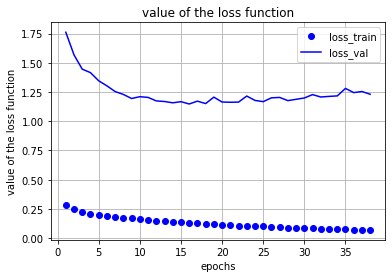

In [37]:
loss = history2.history['loss']
loss_val = history2.history['val_loss']
epochs = range(1, len(loss)+1)
plt.plot(epochs, loss, 'bo', label='loss_train')
plt.plot(epochs, loss_val, 'b', label='loss_val')
plt.title('value of the loss function')
plt.xlabel('epochs')
plt.ylabel('value of the loss function')
plt.legend()
plt.grid()
plt.show()

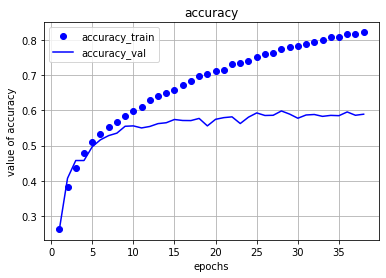

In [38]:
acc = history2.history['accuracy']
acc_val = history2.history['val_accuracy']
epochs = range(1, len(loss)+1)
plt.plot(epochs, acc, 'bo', label='accuracy_train')
plt.plot(epochs, acc_val, 'b', label='accuracy_val')
plt.title('accuracy')
plt.xlabel('epochs')
plt.ylabel('value of accuracy')
plt.legend()
plt.grid()
plt.show()

# 14. Custom Model 3
With Convolution Layers, Pooldown Layer, Droupout Layers, Batch Normalization and Dense Layers

In [39]:
model3 = models.Sequential()

model3.add(Conv2D(64, (1, 1), padding='same', activation='relu', input_shape=(48, 48, 1)))
model3.add(BatchNormalization())
model3.add(Dropout(0.25))

model3.add(Conv2D(128, (3, 3),padding='same', activation='relu'))
model3.add(BatchNormalization())
model3.add(Dropout(0.25))

model3.add(Conv2D(256, (5, 5),padding='same', activation='relu'))
model3.add(BatchNormalization())
model3.add(MaxPool2D((2, 2),padding="same"))
model3.add(Dropout(0.25))


model3.add(Flatten())

model3.add(Dense(128))
model3.add(BatchNormalization())
model3.add(Activation('relu'))
model3.add(Dropout(0.25))

model3.add(Dense(256))
model3.add(BatchNormalization())
model3.add(Activation('relu'))
model3.add(Dropout(0.25))

model3.add(Dense(7, activation='softmax'))

The Model

In [40]:
model3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 48, 48, 64)        128       
_________________________________________________________________
batch_normalization (BatchNo (None, 48, 48, 64)        256       
_________________________________________________________________
dropout_5 (Dropout)          (None, 48, 48, 64)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 48, 48, 128)       73856     
_________________________________________________________________
batch_normalization_1 (Batch (None, 48, 48, 128)       512       
_________________________________________________________________
dropout_6 (Dropout)          (None, 48, 48, 128)       0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 48, 48, 256)      

Compiling the Model

In [41]:
model3.compile(optimizer=Adam(learning_rate=1e-3), loss='categorical_crossentropy', metrics=['accuracy'])

Training the Model

In [42]:
history3 = model3.fit(train_images, train_labels,
                    validation_data=(val_images, val_labels),
                    callbacks=callbackFunction('Case_3'),
                    class_weight = class_weight,
                    epochs=50,
                    batch_size=64)

Epoch 1/50
449/449 [==============================] - 25s 50ms/step - loss: 0.2764 - accuracy: 0.3291 - val_loss: 1.8138 - val_accuracy: 0.3188

Epoch 00001: val_accuracy improved from -inf to 0.31875, saving model to Checkpoints/Case_3.h5
Epoch 2/50
449/449 [==============================] - 21s 48ms/step - loss: 0.2253 - accuracy: 0.4394 - val_loss: 1.3660 - val_accuracy: 0.4745

Epoch 00002: val_accuracy improved from 0.31875 to 0.47451, saving model to Checkpoints/Case_3.h5
Epoch 3/50
449/449 [==============================] - 21s 48ms/step - loss: 0.1987 - accuracy: 0.5097 - val_loss: 1.3144 - val_accuracy: 0.5107

Epoch 00003: val_accuracy improved from 0.47451 to 0.51073, saving model to Checkpoints/Case_3.h5
Epoch 4/50
449/449 [==============================] - 21s 47ms/step - loss: 0.1762 - accuracy: 0.5640 - val_loss: 1.2565 - val_accuracy: 0.5400

Epoch 00004: val_accuracy improved from 0.51073 to 0.53998, saving model to Checkpoints/Case_3.h5
Epoch 5/50
449/449 [===========

Accuracy

In [43]:
train_loss, train_acc = model3.evaluate(train_images, train_labels)
print('Train Accuracy:', train_acc*100)
print('\n')

test_loss, test_acc = model3.evaluate(test_images, test_labels)
print('Test Accuracy:', test_acc*100)
print('\n')

val_loss, val_acc = model3.evaluate(val_images, val_labels)
print('Validation Accuracy:', val_acc*100)

898/898 [==============================] - 8s 9ms/step - loss: 0.0158 - accuracy: 0.9945
Train Accuracy: 99.45313334465027


113/113 [==============================] - 1s 9ms/step - loss: 2.3985 - accuracy: 0.5531
Test Accuracy: 55.3078830242157


113/113 [==============================] - 1s 9ms/step - loss: 2.2871 - accuracy: 0.5793
Validation Accuracy: 57.927000522613525


Predictions

In [44]:
pred_test_labels3 = model3.predict(test_images)

Plots

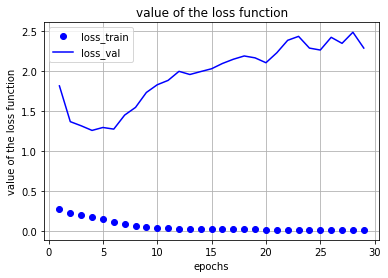

In [45]:
loss = history3.history['loss']
loss_val = history3.history['val_loss']
epochs = range(1, len(loss)+1)
plt.plot(epochs, loss, 'bo', label='loss_train')
plt.plot(epochs, loss_val, 'b', label='loss_val')
plt.title('value of the loss function')
plt.xlabel('epochs')
plt.ylabel('value of the loss function')
plt.legend()
plt.grid()
plt.show()

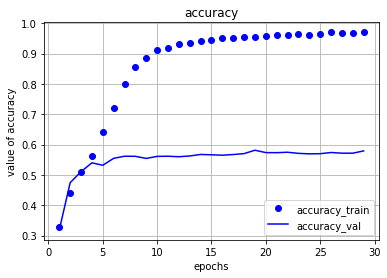

In [46]:
acc = history3.history['accuracy']
acc_val = history3.history['val_accuracy']
epochs = range(1, len(loss)+1)
plt.plot(epochs, acc, 'bo', label='accuracy_train')
plt.plot(epochs, acc_val, 'b', label='accuracy_val')
plt.title('accuracy')
plt.xlabel('epochs')
plt.ylabel('value of accuracy')
plt.legend()
plt.grid()
plt.show()

# 15. Analyzing the Results

For Model 1

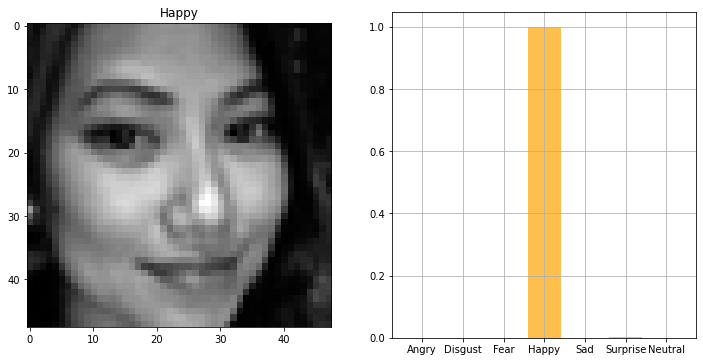

In [47]:
plot_image_and_emotion(test_image_array, test_image_label, pred_test_labels1, 19)

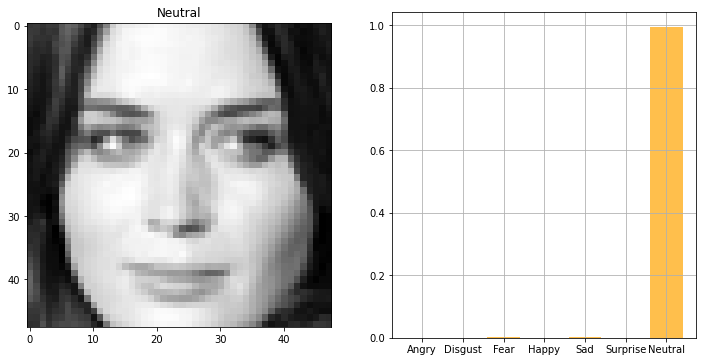

In [48]:
plot_image_and_emotion(test_image_array, test_image_label, pred_test_labels1, 119)

Form Model 2

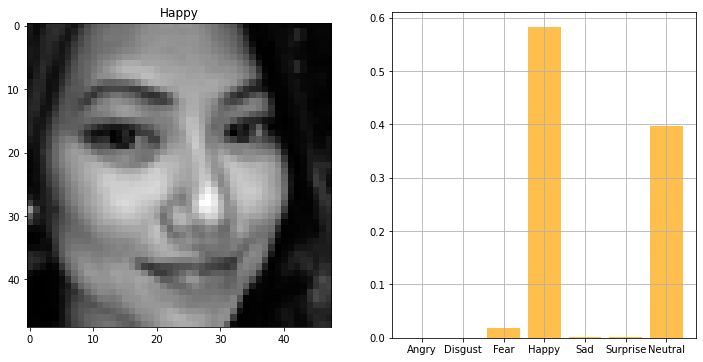

In [49]:
plot_image_and_emotion(test_image_array, test_image_label, pred_test_labels2, 19)

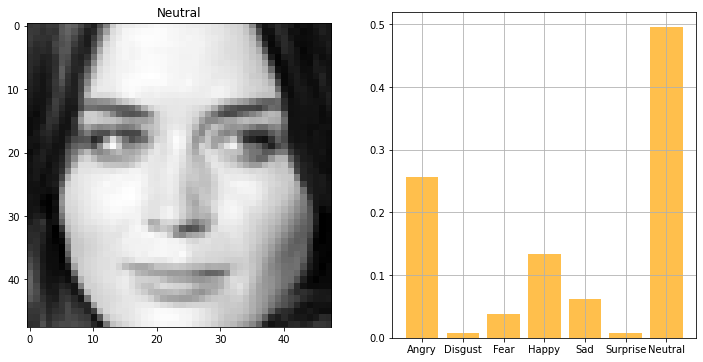

In [50]:
plot_image_and_emotion(test_image_array, test_image_label, pred_test_labels2, 119)

For Model 3

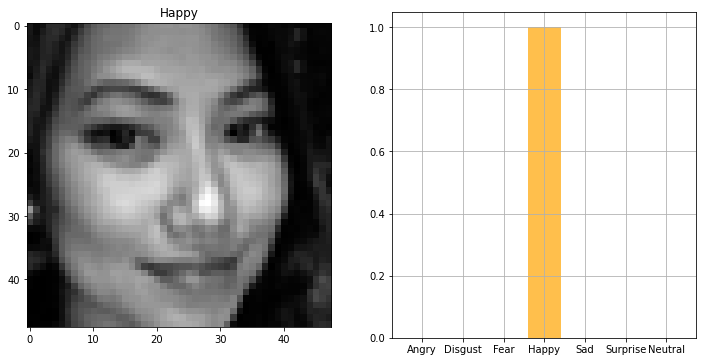

In [51]:
plot_image_and_emotion(test_image_array, test_image_label, pred_test_labels3, 19)

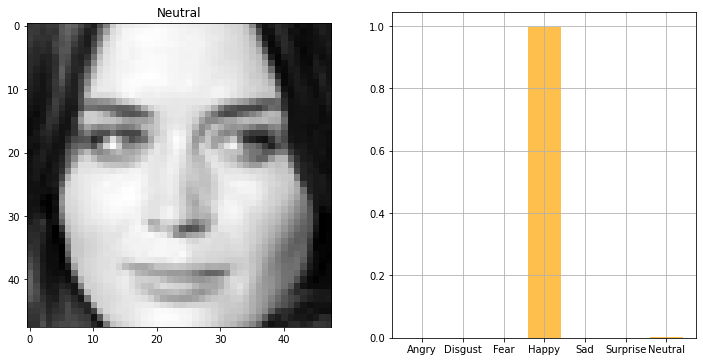

In [52]:
plot_image_and_emotion(test_image_array, test_image_label, pred_test_labels3, 119)

# 16. Predicted Label Comparision Plot

Model 1

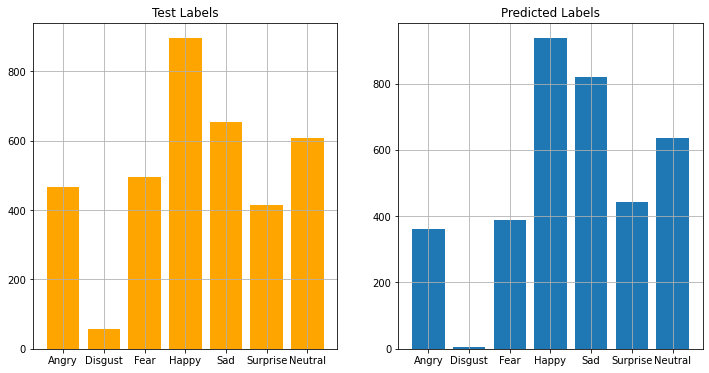

In [53]:
plot_compare_distributions(test_labels, pred_test_labels1, title1='Test Labels', title2='Predicted Labels')

Model 2

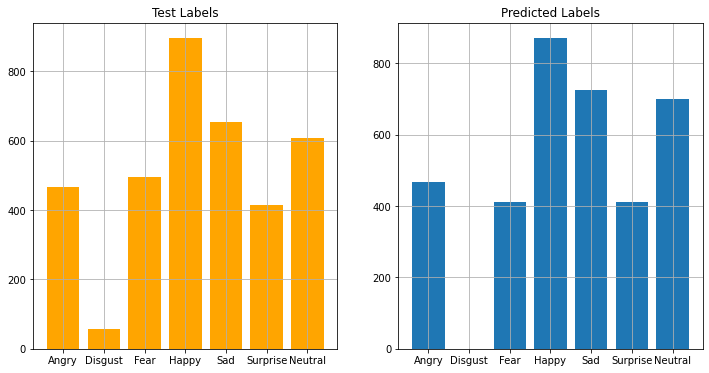

In [54]:
plot_compare_distributions(test_labels, pred_test_labels2, title1='Test Labels', title2='Predicted Labels')

Model 3

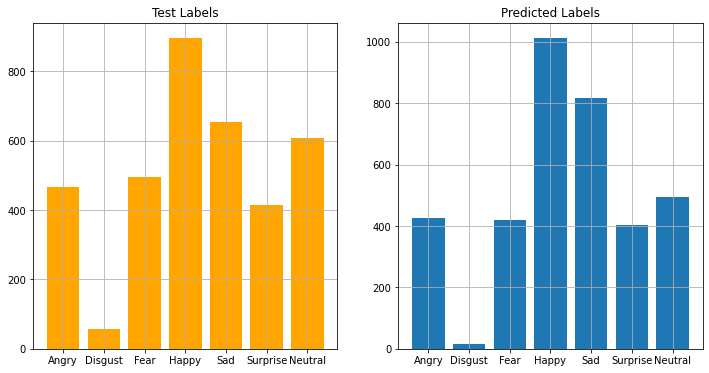

In [55]:
plot_compare_distributions(test_labels, pred_test_labels3, title1='Test Labels', title2='Predicted Labels')

# 17. Analysis of Incorrect Prediction

We are using Confusion Matrix in this case.

Model 1

In [56]:
df_compare = pd.DataFrame()
df_compare['real'] = test_labels.argmax(axis=1)
df_compare['pred'] = pred_test_labels1.argmax(axis=1)
df_compare['wrong'] = np.where(df_compare['real']!=df_compare['pred'], 1, 0)

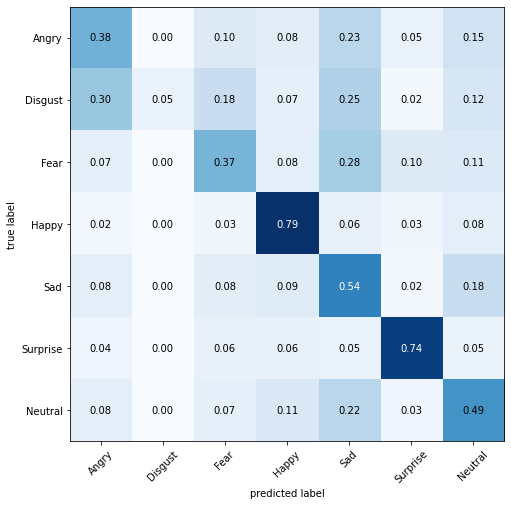

In [57]:
conf_mat = confusion_matrix(test_labels.argmax(axis=1), pred_test_labels1.argmax(axis=1))

fig, ax = plot_confusion_matrix(conf_mat=conf_mat,
                                show_normed=True,
                                show_absolute=False,
                                class_names=emotions.values(),
                                figsize=(8, 8))
fig.show()

Model 2

In [58]:
df_compare = pd.DataFrame()
df_compare['real'] = test_labels.argmax(axis=1)
df_compare['pred'] = pred_test_labels2.argmax(axis=1)
df_compare['wrong'] = np.where(df_compare['real']!=df_compare['pred'], 1, 0)

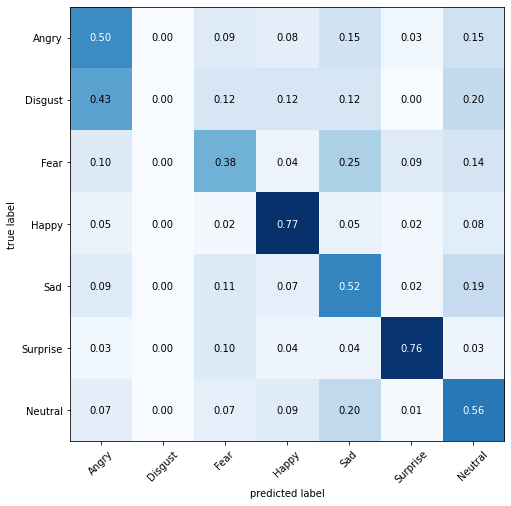

In [59]:
conf_mat = confusion_matrix(test_labels.argmax(axis=1), pred_test_labels2.argmax(axis=1))

fig, ax = plot_confusion_matrix(conf_mat=conf_mat,
                                show_normed=True,
                                show_absolute=False,
                                class_names=emotions.values(),
                                figsize=(8, 8))
fig.show()

Model 3

In [60]:
df_compare = pd.DataFrame()
df_compare['real'] = test_labels.argmax(axis=1)
df_compare['pred'] = pred_test_labels2.argmax(axis=1)
df_compare['wrong'] = np.where(df_compare['real']!=df_compare['pred'], 1, 0)

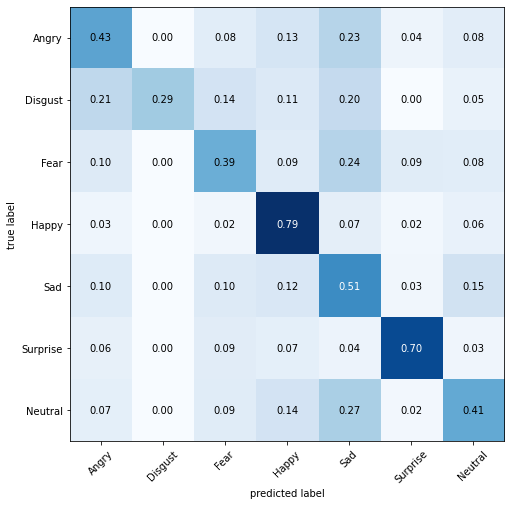

In [61]:
conf_mat = confusion_matrix(test_labels.argmax(axis=1), pred_test_labels3.argmax(axis=1))

fig, ax = plot_confusion_matrix(conf_mat=conf_mat,
                                show_normed=True,
                                show_absolute=False,
                                class_names=emotions.values(),
                                figsize=(8, 8))
fig.show()